#### This code reads packetloss data for one site and runs anomaly detection on it.

In [1]:
%matplotlib inline
from os import listdir
from time import time

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

from sklearn.model_selection import train_test_split

from pandas.tseries.offsets import *

Using TensorFlow backend.


#### parameters to set

In [14]:
# tuning parameters
ref = 24
sub = 1
path='../'

chance = ref/(sub+ref)
cut = chance + (1-chance) * 0.05
print('chance:',chance, '\tcut:', cut)
ref = ref * Hour()
sub = sub * Hour()

chance: 0.96 	cut: 0.962


### create Network Model

In [15]:
def scaled_accuracy(accuracy, ref_samples, sub_samples):
    chance = float(ref_samples)/(ref_samples+sub_samples)
    rescale = 1/(1 - chance)
    return (accuracy-chance)*rescale

class ANN(object):
    def __init__(self, df, auc_df):
        self.n_series = df.shape[1]
        self.df = df
        self.auc_df = auc_df
        
        self.nn = Sequential()
        self.nn.add(Dense(units=self.n_series*2, input_shape=(self.n_series,), activation='relu' ))
#       self.nn.add(Dropout(0.5))
        self.nn.add(Dense(units=self.n_series, activation='relu'))
#       self.nn.add(Dropout(0.5))
        self.nn.add(Dense(units=1, activation='sigmoid'))
#       self.nn.compile(loss='hinge', optimizer='sgd', metrics=['binary_accuracy'])
#       self.nn.compile(loss='mse',optimizer='rmsprop', metrics=['accuracy'])
        self.nn.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
#       self.nn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
        self.nn.summary()
    
    def plot_hist(self, hist):
        es=len(hist.history['loss'])
        x = np.linspace(0,es-1,es)
        plt.plot(x, hist.history['loss'], '--', linewidth=2, label='loss')
        plt.plot(x, hist.history['acc'], '-', linewidth=2, label='acc')
        plt.legend()
        plt.show()
    
    def check_for_anomaly(self,ref, sub, count):
    
        y_ref = pd.Series([0] * ref.shape[0])
        X_ref = ref
    
        y_sub = pd.Series([1] * sub.shape[0])
        X_sub = sub
        
        # separate Reference and Subject into Train and Test
        X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
        X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
        # combine training ref and sub samples
        X_train = pd.concat([X_ref_train, X_sub_train])
        y_train = pd.concat([y_ref_train, y_sub_train])

        # combine testing ref and sub samples
        X_test = pd.concat([X_ref_test, X_sub_test])
        y_test = pd.concat([y_ref_test, y_sub_test])
    
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
    
        X_train_s, y_train_s = shuffle(X_train, y_train)
    
#         with tf.device('/gpu:0'):
        hist = self.nn.fit(X_train_s.values, y_train_s.values, epochs=100, verbose=0, shuffle=True, batch_size=10)
        loss_and_metrics = self.nn.evaluate(X_test.values, y_test.values)#, batch_size=256)
        print(loss_and_metrics)
        
        return scaled_accuracy(loss_and_metrics[1], ref.shape[0], sub.shape[0])
    
    
    def loop_over_intervals(self):
        lstart = self.df.index.min()
        lend = self.df.index.max()

        #round start 
        lstart.seconds=0
        lstart.minutes=0

        # loop over them
        ti = lstart + ref + sub
        count = 0
        while ti < lend + 1 * Minute():
            print(count)
            startt = time()
            ref_start = ti-ref-sub
            ref_end = ti-sub
            ref_df = self.df[(self.df.index >= ref_start) & (self.df.index < ref_end)]
            sub_df = self.df[(self.df.index >= ref_end) & (self.df.index < ti)]
            if sub_df.shape[0]>60 * 0.7 and ref_df.shape[0]>24*60*0.7:
                score = self.check_for_anomaly(ref_df, sub_df, count)
            else:
                score = 0
            self.auc_df.loc[(self.auc_df.index >= ref_end) & (self.auc_df.index < ti), ['score']]  = score
            print('\n',ti,"\trefes:" , ref_df.shape, "\tsubjects:", sub_df.shape, '\tacc:', score)
            ti = ti + sub
            print("took:", time()-startt)
            count = count + 1
            #if count>2: break    
    

Processing: 164.113.255.2.h5
(218035, 2)
(3000, 2)
2017-05-10 00:00:00 2017-05-12 01:59:00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 3         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
0
 32/450 [=>............................] - ETA: 1s[0.16809258831871882, 0.95999999999999996]

 2017-05-11 01:00:00 	refes: (1440, 2) 	subjects: (60, 2) 	acc: 0.0
took: 40.916197538375854
1
 32/450 [=>............................] - ETA: 0s[0.16808931986490885, 0.95999999999999996]

 2017-05-11 02:00:00 	refes: (1440

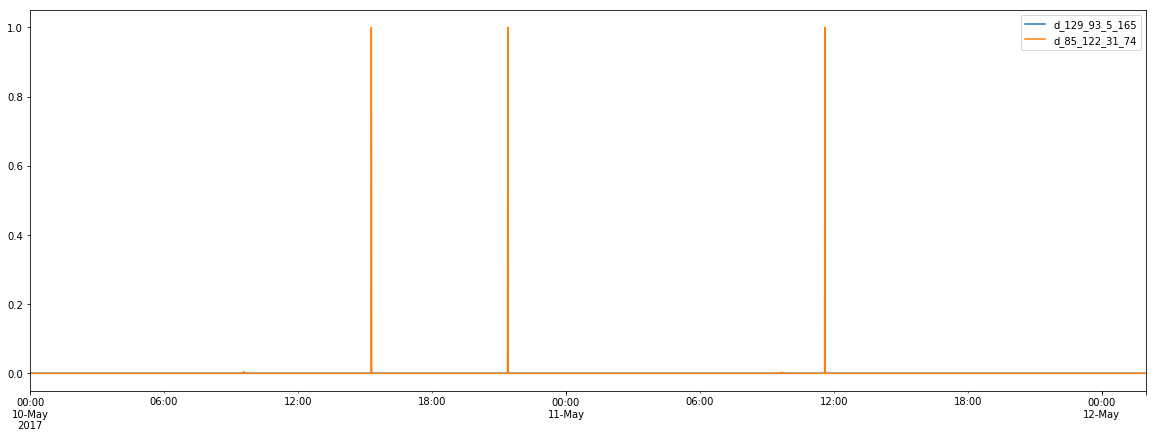

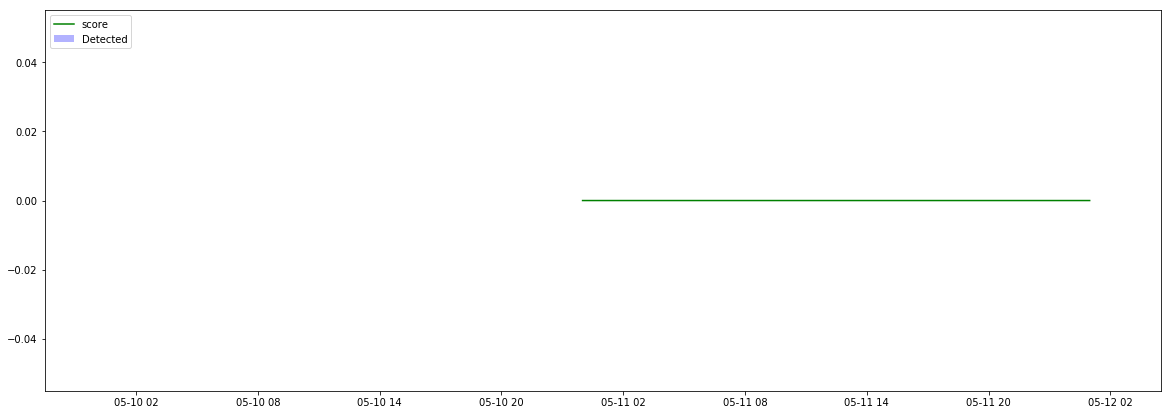

Processing: 2607:f388:107c:502::b.h5
(147, 1)
(147, 1)
2017-05-10 20:38:00 2017-10-10 13:50:00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 2)                 4         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 3         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 2         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
0

 2017-05-11 21:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004571199417114258
1

 2017-05-11 22:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003682374954223633
2

 2017-05-11 23:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036377906799316406
3

 2017-05-12 00:38:00 	refes: (1, 1) 	


 2017-05-15 07:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0037021636962890625
83

 2017-05-15 08:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036606788635253906
84

 2017-05-15 09:38:00 	refes: (1, 1) 	subjects: (1, 1) 	acc: 0
took: 0.0036575794219970703
85

 2017-05-15 10:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035636425018310547
86

 2017-05-15 11:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003430604934692383
87

 2017-05-15 12:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0034880638122558594
88

 2017-05-15 13:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003545522689819336
89

 2017-05-15 14:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003597736358642578
90

 2017-05-15 15:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0034067630767822266
91

 2017-05-15 16:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035500526428222656
92

 2017-05-15 17:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0



 2017-05-20 03:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003791332244873047
199

 2017-05-20 04:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035681724548339844
200

 2017-05-20 05:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0034453868865966797
201

 2017-05-20 06:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003625631332397461
202

 2017-05-20 07:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036468505859375
203

 2017-05-20 08:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036237239837646484
204

 2017-05-20 09:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035479068756103516
205

 2017-05-20 10:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003487825393676758
206

 2017-05-20 11:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036230087280273438
207

 2017-05-20 12:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036346912384033203
208

 2017-05-20 13:38:00 	refes: (0, 1) 	subjects: (0, 1) 	

 2017-05-27 19:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003622770309448242
383

 2017-05-27 20:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003652811050415039
384

 2017-05-27 21:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003634214401245117
385

 2017-05-27 22:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003484487533569336
386

 2017-05-27 23:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035386085510253906
387

 2017-05-28 00:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003521442413330078
388

 2017-05-28 01:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003582000732421875
389

 2017-05-28 02:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035567283630371094
390

 2017-05-28 03:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042877197265625
391

 2017-05-28 04:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004514455795288086
392

 2017-05-28 05:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 


 2017-06-04 06:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035796165466308594
562

 2017-06-04 07:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035262107849121094
563

 2017-06-04 08:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035400390625
564

 2017-06-04 09:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00357818603515625
565

 2017-06-04 10:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0037126541137695312
566

 2017-06-04 11:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0037114620208740234
567

 2017-06-04 12:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003643512725830078
568

 2017-06-04 13:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003662586212158203
569

 2017-06-04 14:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003656625747680664
570

 2017-06-04 15:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036153793334960938
571

 2017-06-04 16:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 

 2017-06-07 21:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003710031509399414
649

 2017-06-07 22:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003699064254760742
650

 2017-06-07 23:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003794431686401367
651

 2017-06-08 00:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003621816635131836
652

 2017-06-08 01:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0037415027618408203
653

 2017-06-08 02:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0037102699279785156
654

 2017-06-08 03:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0037031173706054688
655

 2017-06-08 04:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003704547882080078
656

 2017-06-08 05:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003651857376098633
657

 2017-06-08 06:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003624439239501953
658

 2017-06-08 07:38:00 	refes: (1, 1) 	subjects: (0, 1) 	ac

 2017-06-11 12:38:00 	refes: (1, 1) 	subjects: (1, 1) 	acc: 0
took: 0.003713846206665039
736

 2017-06-11 13:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003771066665649414
737

 2017-06-11 14:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003812074661254883
738

 2017-06-11 15:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0037164688110351562
739

 2017-06-11 16:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0037529468536376953
740

 2017-06-11 17:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0037038326263427734
741

 2017-06-11 18:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0037484169006347656
742

 2017-06-11 19:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0037872791290283203
743

 2017-06-11 20:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003763914108276367
744

 2017-06-11 21:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003798246383666992
745

 2017-06-11 22:38:00 	refes: (2, 1) 	subjects: (0, 1) 	

 2017-06-15 16:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035393238067626953
836

 2017-06-15 17:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035021305084228516
837

 2017-06-15 18:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035440921783447266
838

 2017-06-15 19:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036194324493408203
839

 2017-06-15 20:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036191940307617188
840

 2017-06-15 21:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003609180450439453
841

 2017-06-15 22:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035436153411865234
842

 2017-06-15 23:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0034780502319335938
843

 2017-06-16 00:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0034918785095214844
844

 2017-06-16 01:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0373537540435791
845

 2017-06-16 02:38:00 	refes: (1, 1) 	subjects: (0, 1) 

 2017-06-19 10:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036602020263671875
926

 2017-06-19 11:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035140514373779297
927

 2017-06-19 12:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036847591400146484
928

 2017-06-19 13:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036575794219970703
929

 2017-06-19 14:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036661624908447266
930

 2017-06-19 15:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036296844482421875
931

 2017-06-19 16:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036373138427734375
932

 2017-06-19 17:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0037043094635009766
933

 2017-06-19 18:38:00 	refes: (0, 1) 	subjects: (1, 1) 	acc: 0
took: 0.003661632537841797
934

 2017-06-19 19:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036649703979492188
935

 2017-06-19 20:38:00 	refes: (1, 1) 	subjects: (0, 

 2017-06-26 22:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003658294677734375
1106

 2017-06-26 23:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003620624542236328
1107

 2017-06-27 00:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003682374954223633
1108

 2017-06-27 01:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036287307739257812
1109

 2017-06-27 02:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0034906864166259766
1110

 2017-06-27 03:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003608226776123047
1111

 2017-06-27 04:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003612041473388672
1112

 2017-06-27 05:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003586292266845703
1113

 2017-06-27 06:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035920143127441406
1114

 2017-06-27 07:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036110877990722656
1115

 2017-06-27 08:38:00 	refes: (1, 1) 	subjects:

 2017-06-30 20:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036563873291015625
1200

 2017-06-30 21:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036656856536865234
1201

 2017-06-30 22:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003728151321411133
1202

 2017-06-30 23:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003530740737915039
1203

 2017-07-01 00:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003537893295288086
1204

 2017-07-01 01:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003641366958618164
1205

 2017-07-01 02:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003687620162963867
1206

 2017-07-01 03:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036678314208984375
1207

 2017-07-01 04:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.03850984573364258
1208

 2017-07-01 05:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004549503326416016
1209

 2017-07-01 06:38:00 	refes: (1, 1) 	subjects: (

took: 0.003415346145629883
1292

 2017-07-04 17:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003618955612182617
1293

 2017-07-04 18:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035889148712158203
1294

 2017-07-04 19:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003616809844970703
1295

 2017-07-04 20:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00350189208984375
1296

 2017-07-04 21:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003495931625366211
1297

 2017-07-04 22:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035719871520996094
1298

 2017-07-04 23:38:00 	refes: (0, 1) 	subjects: (1, 1) 	acc: 0
took: 0.03736233711242676
1299

 2017-07-05 00:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003980398178100586
1300

 2017-07-05 01:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0038836002349853516
1301

 2017-07-05 02:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036249160766601562
1302

 2017-07-05 03:

 2017-07-08 06:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003710508346557617
1378

 2017-07-08 07:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036551952362060547
1379

 2017-07-08 08:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036759376525878906
1380

 2017-07-08 09:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0037221908569335938
1381

 2017-07-08 10:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035898685455322266
1382

 2017-07-08 11:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035576820373535156
1383

 2017-07-08 12:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036330223083496094
1384

 2017-07-08 13:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003698587417602539
1385

 2017-07-08 14:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003714323043823242
1386

 2017-07-08 15:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036211013793945312
1387

 2017-07-08 16:38:00 	refes: (0, 1) 	subjec

 2017-07-11 23:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0035080909729003906
1467

 2017-07-12 00:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0034923553466796875
1468

 2017-07-12 01:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036454200744628906
1469

 2017-07-12 02:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003741741180419922
1470

 2017-07-12 03:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036902427673339844
1471

 2017-07-12 04:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003660440444946289
1472

 2017-07-12 05:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003697633743286133
1473

 2017-07-12 06:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003735780715942383
1474

 2017-07-12 07:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0036683082580566406
1475

 2017-07-12 08:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.003645181655883789
1476

 2017-07-12 09:38:00 	refes: (1, 1) 	subjects

 2017-07-18 11:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004228115081787109
1623

 2017-07-18 12:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004153251647949219
1624

 2017-07-18 13:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004225492477416992
1625

 2017-07-18 14:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004212379455566406
1626

 2017-07-18 15:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004328250885009766
1627

 2017-07-18 16:38:00 	refes: (1, 1) 	subjects: (1, 1) 	acc: 0
took: 0.004206180572509766
1628

 2017-07-18 17:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004230499267578125
1629

 2017-07-18 18:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004086971282958984
1630

 2017-07-18 19:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0041849613189697266
1631

 2017-07-18 20:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004218578338623047
1632

 2017-07-18 21:38:00 	refes: (1, 1) 	subjects: (0


 2017-07-22 06:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004213809967041016
1714

 2017-07-22 07:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004237651824951172
1715

 2017-07-22 08:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00415349006652832
1716

 2017-07-22 09:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004212141036987305
1717

 2017-07-22 10:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004247188568115234
1718

 2017-07-22 11:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004212856292724609
1719

 2017-07-22 12:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00421452522277832
1720

 2017-07-22 13:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004101276397705078
1721

 2017-07-22 14:38:00 	refes: (0, 1) 	subjects: (1, 1) 	acc: 0
took: 0.004262685775756836
1722

 2017-07-22 15:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004140377044677734
1723

 2017-07-22 16:38:00 	refes: (1, 1) 	subjects: (0, 

 2017-07-25 23:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004221677780151367
1803

 2017-07-26 00:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004210710525512695
1804

 2017-07-26 01:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0041348934173583984
1805

 2017-07-26 02:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004218339920043945
1806

 2017-07-26 03:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004156351089477539
1807

 2017-07-26 04:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00421142578125
1808

 2017-07-26 05:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004241943359375
1809

 2017-07-26 06:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004214048385620117
1810

 2017-07-26 07:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004143238067626953
1811

 2017-07-26 08:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042247772216796875
1812

 2017-07-26 09:38:00 	refes: (1, 1) 	subjects: (0, 1) 	

1893

 2017-07-29 18:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00422215461730957
1894

 2017-07-29 19:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004160404205322266
1895

 2017-07-29 20:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004232883453369141
1896

 2017-07-29 21:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004147529602050781
1897

 2017-07-29 22:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004233121871948242
1898

 2017-07-29 23:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004209041595458984
1899

 2017-07-30 00:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004240989685058594
1900

 2017-07-30 01:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004144906997680664
1901

 2017-07-30 02:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004162788391113281
1902

 2017-07-30 03:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00420832633972168
1903

 2017-07-30 04:38:00 	refes: (1, 1) 	subjects:

 2017-08-02 12:38:00 	refes: (1, 1) 	subjects: (1, 1) 	acc: 0
took: 0.004341602325439453
1984

 2017-08-02 13:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004155874252319336
1985

 2017-08-02 14:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004234790802001953
1986

 2017-08-02 15:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004147052764892578
1987

 2017-08-02 16:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004231452941894531
1988

 2017-08-02 17:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004155158996582031
1989

 2017-08-02 18:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042383670806884766
1990

 2017-08-02 19:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004135608673095703
1991

 2017-08-02 20:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004239320755004883
1992

 2017-08-02 21:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004216670989990234
1993

 2017-08-02 22:38:00 	refes: (2, 1) 	subjects: (0

 2017-08-06 07:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004358768463134766
2075

 2017-08-06 08:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004148244857788086
2076

 2017-08-06 09:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004168987274169922
2077

 2017-08-06 10:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042302608489990234
2078

 2017-08-06 11:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004236936569213867
2079

 2017-08-06 12:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042264461517333984
2080

 2017-08-06 13:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004276752471923828
2081

 2017-08-06 14:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004227161407470703
2082

 2017-08-06 15:38:00 	refes: (0, 1) 	subjects: (1, 1) 	acc: 0
took: 0.004235506057739258
2083

 2017-08-06 16:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042116641998291016
2084

 2017-08-06 17:38:00 	refes: (1, 1) 	subjects: 

 2017-08-10 02:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004235744476318359
2166

 2017-08-10 03:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004145145416259766
2167

 2017-08-10 04:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00421905517578125
2168

 2017-08-10 05:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004152536392211914
2169

 2017-08-10 06:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042307376861572266
2170

 2017-08-10 07:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004156589508056641
2171

 2017-08-10 08:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042726993560791016
2172

 2017-08-10 09:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004156589508056641
2173

 2017-08-10 10:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0041806697845458984
2174

 2017-08-10 11:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004233121871948242
2175

 2017-08-10 12:38:00 	refes: (1, 1) 	subjects: (

 2017-08-13 20:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004173994064331055
2256

 2017-08-13 21:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042455196380615234
2257

 2017-08-13 22:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004230022430419922
2258

 2017-08-13 23:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004147768020629883
2259

 2017-08-14 00:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00423741340637207
2260

 2017-08-14 01:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004225492477416992
2261

 2017-08-14 02:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004235267639160156
2262

 2017-08-14 03:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0043506622314453125
2263

 2017-08-14 04:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004242658615112305
2264

 2017-08-14 05:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004237174987792969
2265

 2017-08-14 06:38:00 	refes: (1, 1) 	subjects: (0

 2017-08-17 15:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004149675369262695
2347

 2017-08-17 16:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004328489303588867
2348

 2017-08-17 17:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004149675369262695
2349

 2017-08-17 18:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004230976104736328
2350

 2017-08-17 19:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0041484832763671875
2351

 2017-08-17 20:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004309415817260742
2352

 2017-08-17 21:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004208803176879883
2353

 2017-08-17 22:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004239797592163086
2354

 2017-08-17 23:38:00 	refes: (0, 1) 	subjects: (1, 1) 	acc: 0
took: 0.004144906997680664
2355

 2017-08-18 00:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042417049407958984
2356

 2017-08-18 01:38:00 	refes: (1, 1) 	subjects: (

 2017-08-21 10:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0043222904205322266
2438

 2017-08-21 11:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004325151443481445
2439

 2017-08-21 12:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0041506290435791016
2440

 2017-08-21 13:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004240512847900391
2441

 2017-08-21 14:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004148960113525391
2442

 2017-08-21 15:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042438507080078125
2443

 2017-08-21 16:38:00 	refes: (1, 1) 	subjects: (1, 1) 	acc: 0
took: 0.004217863082885742
2444

 2017-08-21 17:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004188060760498047
2445

 2017-08-21 18:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004195451736450195
2446

 2017-08-21 19:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0041484832763671875
2447

 2017-08-21 20:38:00 	refes: (2, 1) 	subjects:

 2017-08-25 05:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004487752914428711
2529

 2017-08-25 06:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004451751708984375
2530

 2017-08-25 07:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00441288948059082
2531

 2017-08-25 08:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0046079158782958984
2532

 2017-08-25 09:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004288196563720703
2533

 2017-08-25 10:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004231929779052734
2534

 2017-08-25 11:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004244804382324219
2535

 2017-08-25 12:38:00 	refes: (1, 1) 	subjects: (1, 1) 	acc: 0
took: 0.004248380661010742
2536

 2017-08-25 13:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042340755462646484
2537

 2017-08-25 14:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004204988479614258
2538

 2017-08-25 15:38:00 	refes: (1, 1) 	subjects: (0

 2017-08-29 00:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0044879913330078125
2620

 2017-08-29 01:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004136562347412109
2621

 2017-08-29 02:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042209625244140625
2622

 2017-08-29 03:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004155874252319336
2623

 2017-08-29 04:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004235506057739258
2624

 2017-08-29 05:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004147529602050781
2625

 2017-08-29 06:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004220008850097656
2626

 2017-08-29 07:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042116641998291016
2627

 2017-08-29 08:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042438507080078125
2628

 2017-08-29 09:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004221677780151367
2629

 2017-08-29 10:38:00 	refes: (1, 1) 	subjects:

 2017-09-01 19:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004181861877441406
2711

 2017-09-01 20:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004229545593261719
2712

 2017-09-01 21:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00424504280090332
2713

 2017-09-01 22:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004195690155029297
2714

 2017-09-01 23:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004111528396606445
2715

 2017-09-02 00:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004233598709106445
2716

 2017-09-02 01:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004263401031494141
2717

 2017-09-02 02:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004221439361572266
2718

 2017-09-02 03:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0041656494140625
2719

 2017-09-02 04:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004231929779052734
2720

 2017-09-02 05:38:00 	refes: (1, 1) 	subjects: (0, 1)

 2017-09-05 14:38:00 	refes: (1, 1) 	subjects: (1, 1) 	acc: 0
took: 0.004527568817138672
2802

 2017-09-05 15:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00430750846862793
2803

 2017-09-05 16:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0044019222259521484
2804

 2017-09-05 17:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004205942153930664
2805

 2017-09-05 18:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004236936569213867
2806

 2017-09-05 19:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042421817779541016
2807

 2017-09-05 20:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004337787628173828
2808

 2017-09-05 21:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0043103694915771484
2809

 2017-09-05 22:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004158496856689453
2810

 2017-09-05 23:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004171133041381836
2811

 2017-09-06 00:38:00 	refes: (1, 1) 	subjects: (


 2017-09-09 09:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00426173210144043
2893

 2017-09-09 10:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0041599273681640625
2894

 2017-09-09 11:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042324066162109375
2895

 2017-09-09 12:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004246711730957031
2896

 2017-09-09 13:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00424647331237793
2897

 2017-09-09 14:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004158735275268555
2898

 2017-09-09 15:38:00 	refes: (1, 1) 	subjects: (1, 1) 	acc: 0
took: 0.004282951354980469
2899

 2017-09-09 16:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004247426986694336
2900

 2017-09-09 17:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042476654052734375
2901

 2017-09-09 18:38:00 	refes: (2, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0041506290435791016
2902

 2017-09-09 19:38:00 	refes: (1, 1) 	subjects: 

2983

 2017-09-13 04:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0042536258697509766
2984

 2017-09-13 05:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004151344299316406
2985

 2017-09-13 06:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0041811466217041016
2986

 2017-09-13 07:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004172801971435547
2987

 2017-09-13 08:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00416111946105957
2988

 2017-09-13 09:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004227161407470703
2989

 2017-09-13 10:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004282474517822266
2990

 2017-09-13 11:38:00 	refes: (1, 1) 	subjects: (1, 1) 	acc: 0
took: 0.004230022430419922
2991

 2017-09-13 12:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004240989685058594
2992

 2017-09-13 13:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004229307174682617
2993

 2017-09-13 14:38:00 	refes: (1, 1) 	subjec

took: 0.0044116973876953125
3074

 2017-09-16 23:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004349708557128906
3075

 2017-09-17 00:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004172801971435547
3076

 2017-09-17 01:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004286766052246094
3077

 2017-09-17 02:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004236459732055664
3078

 2017-09-17 03:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004153251647949219
3079

 2017-09-17 04:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00415802001953125
3080

 2017-09-17 05:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004259347915649414
3081

 2017-09-17 06:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004234790802001953
3082

 2017-09-17 07:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004240751266479492
3083

 2017-09-17 08:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004240751266479492
3084

 2017-09-17 09:38

took: 0.004589557647705078
3165

 2017-09-20 18:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0044155120849609375
3166

 2017-09-20 19:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004313468933105469
3167

 2017-09-20 20:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0043087005615234375
3168

 2017-09-20 21:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004225492477416992
3169

 2017-09-20 22:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0041577816009521484
3170

 2017-09-20 23:38:00 	refes: (0, 1) 	subjects: (1, 1) 	acc: 0
took: 0.0041577816009521484
3171

 2017-09-21 00:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004147768020629883
3172

 2017-09-21 01:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004232645034790039
3173

 2017-09-21 02:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004223346710205078
3174

 2017-09-21 03:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004235267639160156
3175

 2017-09-21 0

 2017-09-24 12:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004183053970336914
3256

 2017-09-24 13:38:00 	refes: (0, 1) 	subjects: (1, 1) 	acc: 0
took: 0.004235267639160156
3257

 2017-09-24 14:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004227876663208008
3258

 2017-09-24 15:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004232883453369141
3259

 2017-09-24 16:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00422358512878418
3260

 2017-09-24 17:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004235029220581055
3261

 2017-09-24 18:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004153251647949219
3262

 2017-09-24 19:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004221439361572266
3263

 2017-09-24 20:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00415802001953125
3264

 2017-09-24 21:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004235029220581055
3265

 2017-09-24 22:38:00 	refes: (1, 1) 	subjects: (0, 1

 2017-09-28 07:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004308938980102539
3347

 2017-09-28 08:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004232168197631836
3348

 2017-09-28 09:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004142284393310547
3349

 2017-09-28 10:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004235744476318359
3350

 2017-09-28 11:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004164695739746094
3351

 2017-09-28 12:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004235267639160156
3352

 2017-09-28 13:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004248142242431641
3353

 2017-09-28 14:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004246234893798828
3354

 2017-09-28 15:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004152774810791016
3355

 2017-09-28 16:38:00 	refes: (0, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004232168197631836
3356

 2017-09-28 17:38:00 	refes: (0, 1) 	subjects: (0,

 2017-10-02 02:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004307746887207031
3438

 2017-10-02 03:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004158735275268555
3439

 2017-10-02 04:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00423431396484375
3440

 2017-10-02 05:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00415802001953125
3441

 2017-10-02 06:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004222393035888672
3442

 2017-10-02 07:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004152774810791016
3443

 2017-10-02 08:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00434112548828125
3444

 2017-10-02 09:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0041506290435791016
3445

 2017-10-02 10:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004242420196533203
3446

 2017-10-02 11:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004155874252319336
3447

 2017-10-02 12:38:00 	refes: (1, 1) 	subjects: (0, 1

3528

 2017-10-05 21:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004152059555053711
3529

 2017-10-05 22:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004240512847900391
3530

 2017-10-05 23:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.00421452522277832
3531

 2017-10-06 00:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004237174987792969
3532

 2017-10-06 01:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004227638244628906
3533

 2017-10-06 02:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004248142242431641
3534

 2017-10-06 03:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004323720932006836
3535

 2017-10-06 04:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004233837127685547
3536

 2017-10-06 05:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.0041544437408447266
3537

 2017-10-06 06:38:00 	refes: (1, 1) 	subjects: (0, 1) 	acc: 0
took: 0.004243135452270508
3538

 2017-10-06 07:38:00 	refes: (1, 1) 	subject

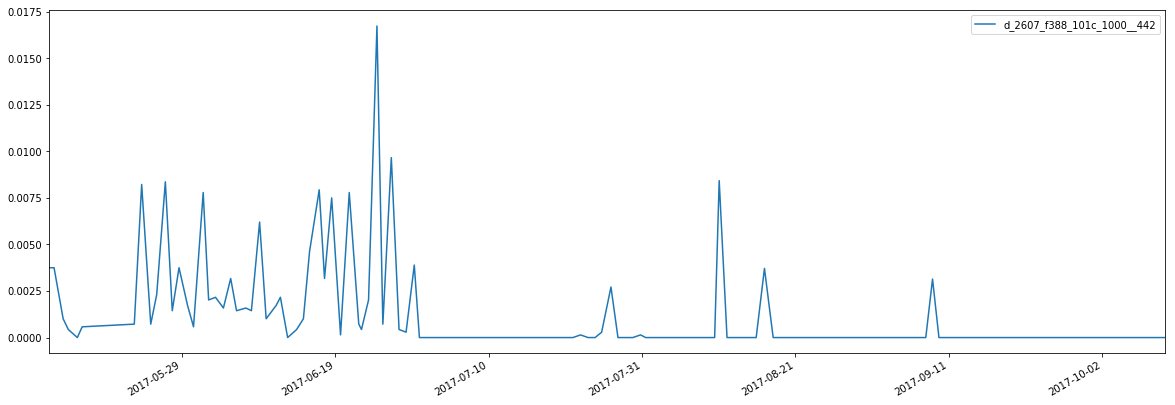

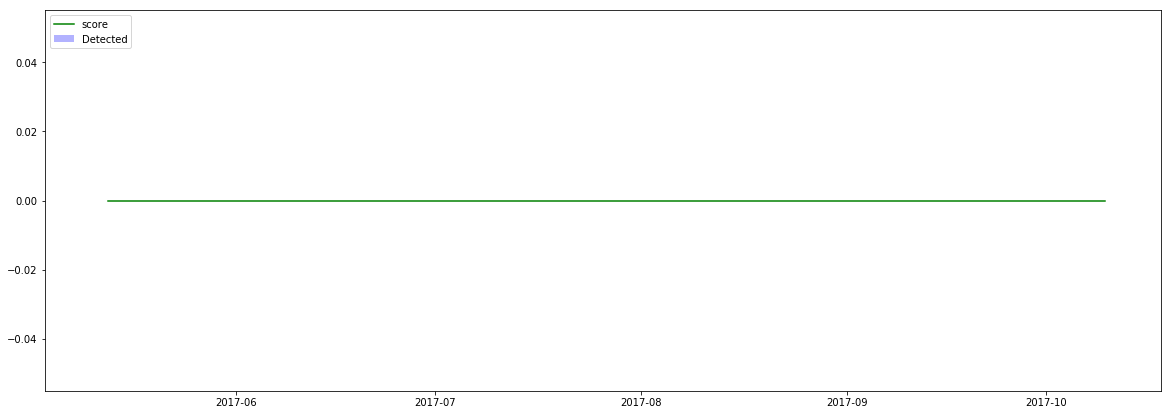

Processing: 206.166.0.130.h5
(17076, 1)
(3000, 1)
2017-07-25 20:17:00 2017-07-27 23:03:00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 2)                 4         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 3         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 2         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
0
 32/448 [=>............................] - ETA: 1s[0.16863196077091352, 0.9598214285714286]

 2017-07-26 21:17:00 	refes: (1432, 1) 	subjects: (60, 1) 	acc: 0.000892857142859
took: 42.61182117462158
1
 32/448 [=>............................] - ETA: 0s[0.16868252493441105, 0.9598214285714286]

 2017-07-26 22:17:00 	refe

KeyboardInterrupt: 

In [17]:
while True:
    objs = listdir(path)
    toProcess=''
    for o in objs:
        if o.endswith('.h5') and "res_"+o not in objs and "proc_"+o not in objs and not o.startswith('res') and not o.startswith('proc'):
            toProcess=o
            f  = open(path + 'proc_' + o, 'w')
            f.write(str(time()))
            f.close()
            break
    if toProcess=='': 
        break
    
    print('Processing:', toProcess)
    full_df = pd.read_hdf(path+toProcess,'data')
    print(full_df.shape)
    full_df = full_df[:3000]
    print(full_df.shape)
    print (full_df.index.min(), full_df.index.max())
    full_df.fillna(0, inplace=True)
    auc_df = pd.DataFrame(np.nan, index=full_df.index, columns=['score'])
    ann = ANN(full_df, auc_df)
    ann.loop_over_intervals()
    
    full_df.plot(figsize=(20,7))

    fig, ax = plt.subplots(figsize=(20,7))
    auc_df['Detected'] = 0
    auc_df.loc[auc_df.score>0.05, ['Detected']]=1
    ax.plot( auc_df.score,'g')
    ax.fill( auc_df.Detected, 'b', alpha=0.3)
    ax.legend(loc='upper left')
    plt.show()
                      
    hdf = pd.HDFStore( 'res_' + o + '.h5')
    hdf.put('result', auc_df, format='table', data_columns=True)
    hdf.close()